In [1]:
colab = False
if (colab):
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/תחלואה/notebooks/data"
else:
  datadir = 'data'

In [2]:
import pandas as pd
import re

%matplotlib inline
xdir = '..' if colab else ''
#Load hospital data
hospital_data = pd.read_pickle(datadir + xdir + "/merged_data_7May2020.pkl")
hospital_data.rename(columns = lambda x : re.sub('\s*:\s*', '_', re.sub('-','_', x)), inplace=True)

In [3]:
print(hospital_data['hospital'].unique())

['AssafHarofe' 'BneiZion' 'Barzilai' 'HilelYaffe' 'Galil' 'Volfson' 'Ziv'
 'Poriya' 'Rambam' 'Shiba']


In [4]:
#Run a smoothing filter on the hospitalization data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (1):
  smoothed_merged_data = hospital_data

  for column in smoothed_merged_data:
    if (column != "Date") and (column != "hospital"):
      smoothed_merged_data[column] = signal.filtfilt(b, a, smoothed_merged_data[column], padlen=7)
      #smoothed_merged_data[column] = smoothed_merged_data[column].rolling(window=14).mean()

  hospital_data = smoothed_merged_data

In [5]:
# Read air quality sensor data
air_quality = pd.read_excel(datadir + "/StationData.xlsx")

air_quality.rename(columns = {'Unnamed: 0' : 'DateTime'}, inplace=True)
air_quality["DateTime"] = pd.to_datetime(air_quality["DateTime"])
air_quality["PollutionDate"] = air_quality["DateTime"].dt.date

# Many columns are empty or sparse. Require 80% availability of data per column
air_quality.dropna(thresh=len(air_quality)*0.8, axis=1, inplace=True)

In [6]:
# Mark columns by the type of pollutants they respectively measure

import re

air_quality.rename(columns=lambda x: re.sub('[- ()+.]','_', re.sub('2\.5', '25', re.sub('_', '__', x))), inplace=True)

colre_gaseous = re.compile('(O3|NO2|NO|NOX|SO2|TOC_SCRUBBER|TOC_RTO|CO|BENZN|O_Xyle|TOLUEN|EthylB|M_P_XY|1_3butadiene|TOL|NOx|H2S|CO TRAFIC|NO2_TRAFIC|NO_TRAFIC|NOX_TRAFIC)$')

colre_particulate = re.compile('(PM10|PM25|pm\(10-2\.5\)|pm_10_25_|DUST|PM1|BLACK CARBON)$')

colre_climate = re.compile('(StWd|RH|WDS|WDD|SR|PREC)$')  # not used, we take climate data from another source
colre_operational = re.compile('(ITemp|TEMP|Filter|LXpk_max|LAF_max|LAF_min|LAim|LXeq|LAeq|FILTER_2.5|spare|PM1_Flow|PM25_Filter|PM10_Noise|PM25_Noise|PM10_Filter|Flow)$')  # not used, this should not matter for anythingg

# There are two data columns which didn't seem to belong anywhere: BP and BRP. Anyone knows what they are?2

all_cols = air_quality.columns

aircols_gaseous = list(filter(colre_gaseous.search, all_cols))
aircols_particulate = list(filter(colre_particulate.search, all_cols))

#print(aircols_gaseous)
#print(aircols_particulate)


In [7]:
#Run a smoothing filter on the air quality data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (0):
  smoothed_filtered_air_quality = filtered_air_quality
  smoothed_filtered_air_quality = smoothed_filtered_air_quality.fillna(-1)

  for column in smoothed_filtered_air_quality:
    if (column != "PollutionDate") and (column != "Date-Time") and (column != "DateTime"): 
      smoothed_filtered_air_quality[column] = signal.filtfilt(b, a, smoothed_filtered_air_quality[column], padlen=14)
      #smoothed_filtered_air_quality[column] = smoothed_filtered_air_quality[column].rolling(window=14).mean()

  filtered_air_quality = smoothed_filtered_air_quality

In [8]:
#Read weather and inversion data
weather = pd.read_csv(datadir + "/weather.csv")

weather.rename(columns=lambda x: re.sub('[- ()+]','_', x), inplace=True)

weather["date"] = pd.to_datetime(weather["date"]).dt.date


In [9]:
# join all independent variables into one table
all_indep = air_quality.merge(weather, how='inner', left_on= "PollutionDate", right_on="date")

In [10]:
# Inner loop of test procedure
# Shift the independent variabls by (lag) days, try to predict the dependent variable, and report 
# the correlation of prediction on a (similarly shifted) test set

import statsmodels.api as sm
import numpy as np
from patsy import dmatrices, dmatrix

def pred_cor(inputs, outputs, lag, formula, hospital):

  inputs["ShiftedPollutionDate"] = pd.DatetimeIndex(inputs["PollutionDate"]) + pd.DateOffset(lag)

  merged_all = pd.merge(outputs, inputs, how='left', left_on='Date', right_on='ShiftedPollutionDate')
  merged_all = merged_all.fillna(-1)

  #Split to train and test
  train_row_mask = (merged_all["hospital"] == hospital) & (merged_all['Date'] <= '2018-12-31')
  test_row_mask  = (merged_all["hospital"] == hospital) & (merged_all['Date'] > '2018-12-31')

  y, X = dmatrices(formula, merged_all)
  y_train = y[train_row_mask]
  X_train = X[train_row_mask]
  y_test = y[test_row_mask]
  y_test = [ i[0] for i in y_test]
  X_test = X[test_row_mask]

  model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
  pred  = model.predict(X_test.astype(float))

  return np.corrcoef(y_test, pred)[0,1]


In [11]:
# Set up sets of features
from itertools import chain, combinations, product

inversion_basic = ['inversion_bywind', 'inversion_bytemp_delta', 'inversion_byboth']
cols_climate = ["hmd_rlt_Bazan", "prs_lvl_hgt_Bazan", "tmp_air_dry_Bazan", "tmp_air_wet_Bazan", "tmp_dew_pnt_Bazan", "wind_dir_Bazan", "wind_spd_Bazan"]

# add pairs of inversion/climate variables
# also include the original inversion variable, and the original climate variables
inversion_cols = inversion_basic.copy()
inversion_cols.extend(map(lambda x: ':'.join(x), product(inversion_basic, cols_climate)))
inversion_cols.extend(cols_climate)

colmap = {
    'gaseous' : aircols_gaseous,
    'particulate' : aircols_particulate,
    'climate' : cols_climate,
    'climate+' : inversion_cols
}

In [20]:
# Main loop

sep = ' + '
sep2 = ','

#hospital = 'Rambam'
#hospital = 'BneiZion'
hospital = 'Shiba'

correlations = {}

all_subsets = chain.from_iterable(combinations(colmap,n) for n in range(1, len(colmap)+1))

for hospital in hospital_data['hospital'].unique():
  colset = ('particulate', 'gaseous')
  colset_name = sep2.join(colset)
  print("\n" + hospital)
  all_lists = (map(lambda x : colmap[x], colset))
  #print(list(all_lists))
  all_items = [item for sublist in all_lists for item in sublist]

  cols = all_items

  formula = sep.join(["all_visits ~ 1", sep.join(cols)])
  #print(formula)

  corrs = pd.DataFrame(columns=['Lag', 'Cor'])

  for lag in range(-60, 60):
    c = pred_cor(all_indep, hospital_data, lag, formula, hospital)
    corrs = corrs.append({'Lag': lag, 'Cor': c }, ignore_index=True)
    print(".", end='')

  correlations[hospital] = corrs


AssafHarofe
........................................................................................................................
BneiZion
........................................................................................................................
Barzilai
........................................................................................................................
HilelYaffe
........................................................................................................................
Galil
........................................................................................................................
Volfson
........................................................................................................................
Ziv
........................................................................................................................
Poriya
......................................................................................

In [18]:
correlations

{'AssafHarofe':       Lag       Cor
 0   -60.0  0.002415
 1   -59.0  0.063632
 2   -58.0  0.126734
 3   -57.0  0.192978
 4   -56.0  0.261994
 5   -55.0  0.297321
 6   -54.0  0.326553
 7   -53.0  0.361659
 8   -52.0  0.403722
 9   -51.0  0.449656
 10  -50.0  0.476096
 11  -49.0  0.472839
 12  -48.0  0.483530
 13  -47.0  0.490276
 14  -46.0  0.493726
 15  -45.0  0.474268
 16  -44.0  0.453235
 17  -43.0  0.425530
 18  -42.0  0.377978
 19  -41.0  0.354840
 20  -40.0  0.295682
 21  -39.0  0.270269
 22  -38.0  0.252578
 23  -37.0  0.241078
 24  -36.0  0.214869
 25  -35.0  0.198475
 26  -34.0  0.204159
 27  -33.0  0.198297
 28  -32.0  0.211537
 29  -31.0  0.229003
 ..    ...       ...
 90   30.0  0.440898
 91   31.0  0.443718
 92   32.0  0.446435
 93   33.0  0.446982
 94   34.0  0.445136
 95   35.0  0.435066
 96   36.0  0.426791
 97   37.0  0.419499
 98   38.0  0.407204
 99   39.0  0.401951
 100  40.0  0.403524
 101  41.0  0.405930
 102  42.0  0.407959
 103  43.0  0.409302
 104  44.0  0.40237

In [13]:
#np.save('data/corr.npy', correlations)

In [14]:
#correlations = np.load('data/corr.npy',allow_pickle='TRUE').item()

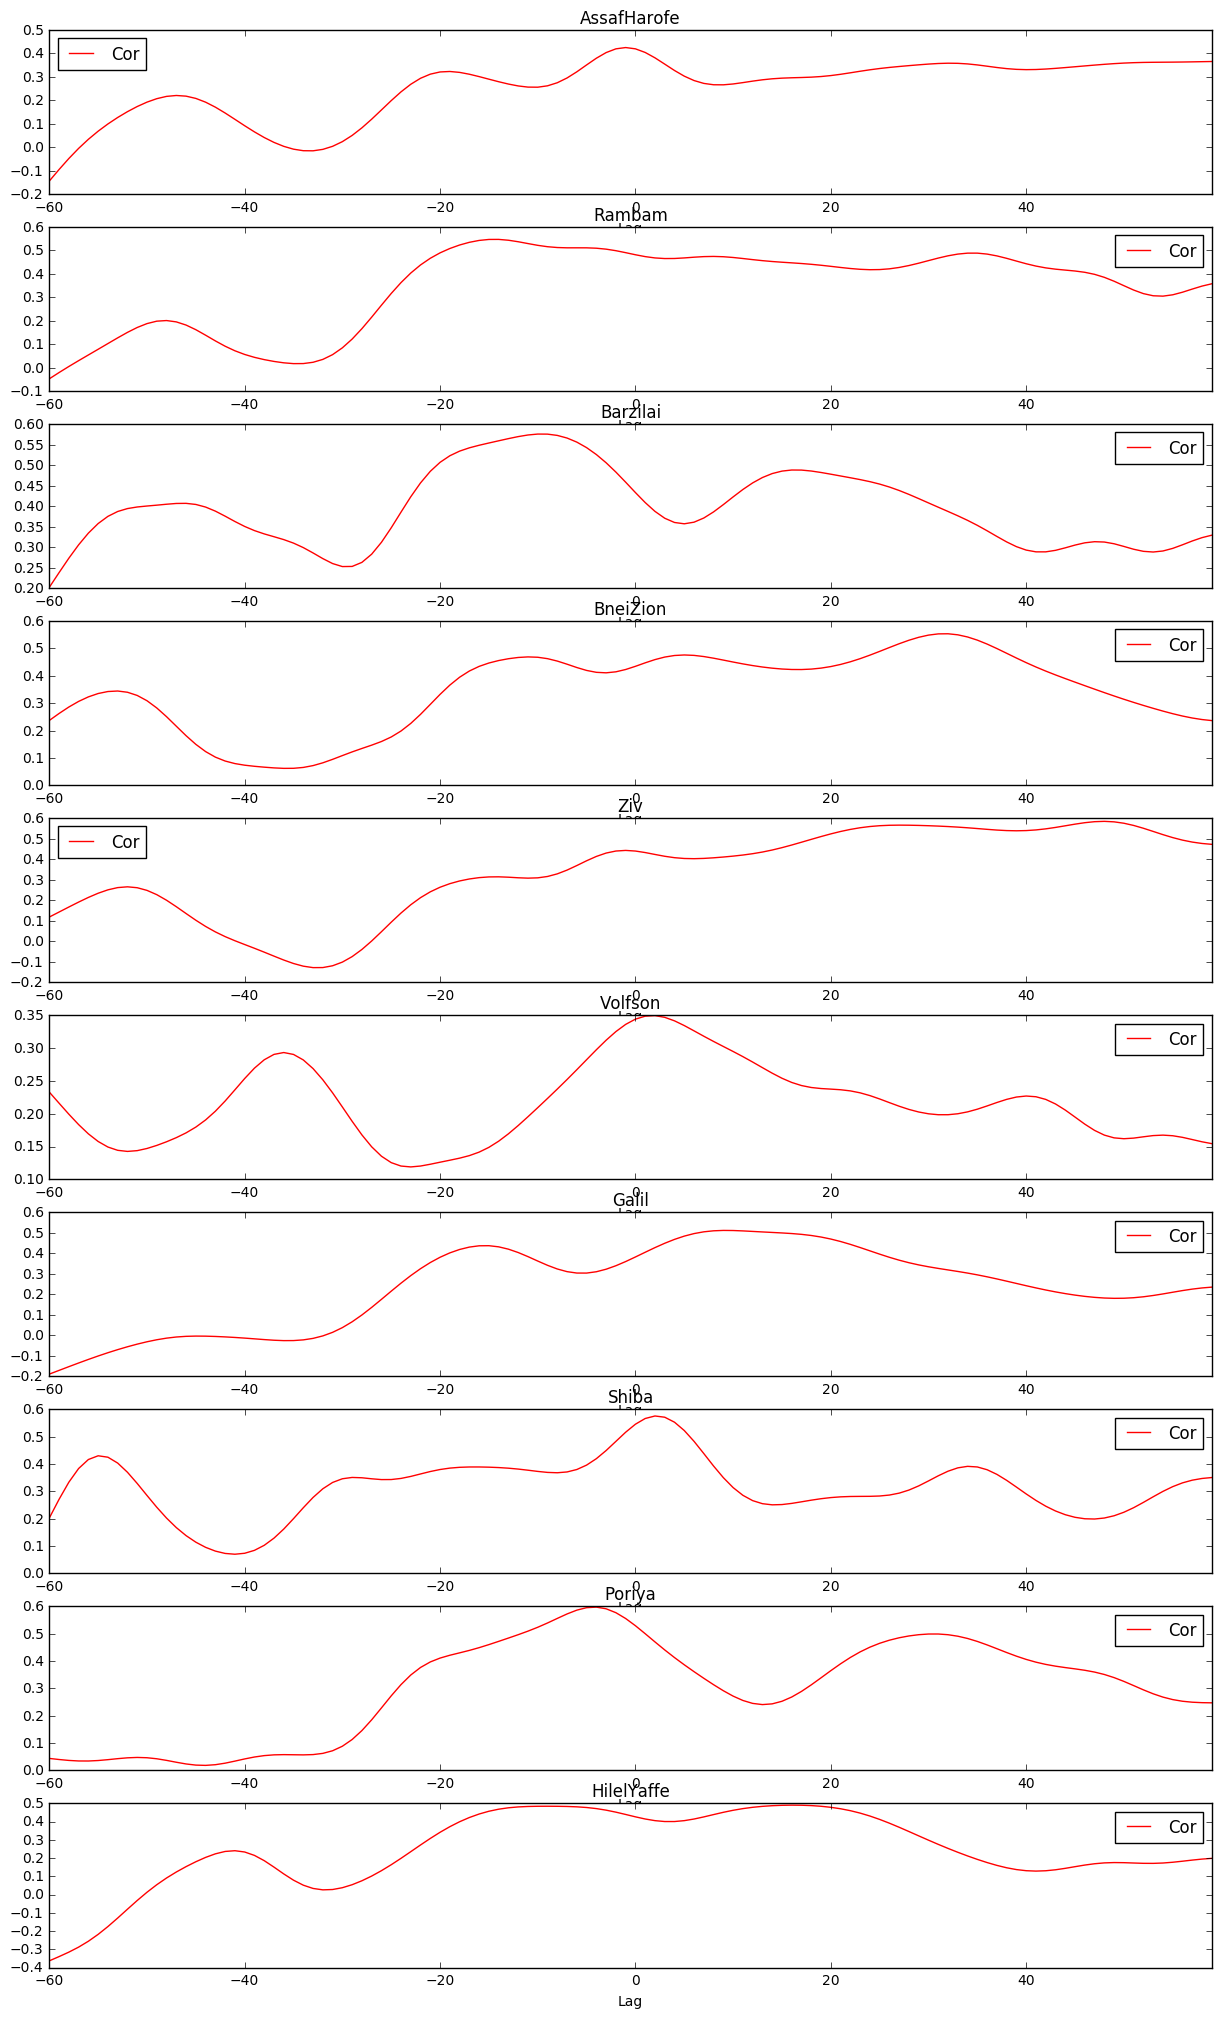

In [21]:
import matplotlib.pyplot as plt

ks = list(correlations.keys())
n = len(ks)

plt.figure()

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(15, 25))

for i in range(len(ks)):
  ki = ks[i]
  b, a = signal.butter(5, 0.2)
  v = correlations[ki].copy()
  y = signal.filtfilt(b, a, v['Cor'], padlen=5)
  v['Cor'] = y
  v.plot(kind='line',x='Lag',y='Cor',color='red', title=ki, ax=axes[i])

plt.show()